In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt

In [29]:
def print_full(x):
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', None)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [41]:
df_train = pd.read_csv("./datasets/train-data-cleaned-v2.csv")
df_test = pd.read_csv("./datasets/test-data-cleaned-v2.csv")

df_train = df_train.loc[:, ~df_train.columns.str.contains('^Unnamed')]
df_test = df_test.loc[:, ~df_test.columns.str.contains('^Unnamed')]

# df_train = df_train.iloc[:,0:29]
# df_test = df_test.iloc[:,0:28]

df_train = df_train.reindex(sorted(df_train.columns), axis=1)
df_test = df_test.reindex(sorted(df_test.columns), axis=1)


print(df_train.shape)
print(df_test.shape)

df_X, df_y = df_train.loc[:, df_train.columns != 'monthly_rent'], df_train['monthly_rent']

X, y = df_X.to_numpy(), df_y.to_numpy()

print_full(df_train.head(1))
print()
print_full(df_test.head(1))


(60000, 79)
(30000, 78)
                0799hk               1792hk               2588hk               a17usi                ap4si                 asln                bn4si               buousi                c07si                c09si               c38usi                c52si                c6lsi               cjlusi                d05si                e5hsi                f34si  flat_model                 flex       floor_area_sqm                g07si                g13si                 grab                 grin                hmnsi               k71usi                  ken                 klic             latitude            longitude               m44usi                 maxn               me8usi  monthly_avg_rent_by_flat_model  monthly_avg_rent_by_planning_area  monthly_avg_rent_by_region  monthly_avg_rent_by_subzone  monthly_avg_rent_per_sqm_by_flat_model  monthly_avg_rent_per_sqm_by_planning_area  monthly_avg_rent_per_sqm_by_region  monthly_avg_rent_per_sqm_by_subzone  monthly_r

In [31]:
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_validate

In [32]:
%%time

# Only considered hyperparameter: max depth of trees
param_choices = [1, 2, 3, 5, 8, 10, 12, 15, 20, 25, 50, 100,150,200]
# param_choices = [100,150,200]

# Keep track of results for visualization
param_to_scores = {}

for param in param_choices:

    # Train regressor with the current parameter setting
    # regressor = DecisionTreeRegressor(max_depth=param)
    regressor = RandomForestRegressor(max_depth=param)
    # regressor = GradientBoostingRegressor(max_depth=param)
    
    # Perform 10-fold cross_validations
    scores = cross_validate(regressor, X, y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
    
    # Extract the 10 RSME scores (training scores and validation scores) for each run/fold
    # The (-1) is only needed since we get the negative root mean squared errors (it's a sklearn thing)
    rsme_train = scores['train_score'] * (-1)
    rsme_valid = scores['test_score'] * (-1)
    
    ## Keep track of all num_folds f1 scores for current param (for plotting)
    param_to_scores[param] = (rsme_train, rsme_valid)
    
    ## Print statement for some immediate feedback (values in parenthesis represent the Standard Deviation)
    print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
          .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

param = 1, RSME training = 613.4 (0.7), RSME validation = 613.6 (7.3)
param = 2, RSME training = 566.4 (0.7), RSME validation = 566.6 (7.6)
param = 3, RSME training = 537.3 (0.7), RSME validation = 538.6 (6.8)
param = 5, RSME training = 506.3 (0.8), RSME validation = 509.3 (7.6)
param = 8, RSME training = 477.3 (0.8), RSME validation = 492.3 (6.7)
param = 10, RSME training = 455.7 (0.9), RSME validation = 489.7 (6.7)
param = 12, RSME training = 426.8 (0.9), RSME validation = 490.9 (6.6)
param = 15, RSME training = 372.3 (0.9), RSME validation = 497.2 (6.6)
param = 20, RSME training = 285.3 (0.7), RSME validation = 511.6 (6.5)
param = 25, RSME training = 241.5 (1.0), RSME validation = 520.2 (6.9)
param = 50, RSME training = 226.1 (0.7), RSME validation = 523.7 (6.3)
param = 100, RSME training = 226.3 (0.5), RSME validation = 524.1 (6.6)
param = 150, RSME training = 226.3 (0.7), RSME validation = 523.8 (6.7)
param = 200, RSME training = 226.3 (0.6), RSME validation = 524.1 (6.6)
Wall tim

In [37]:
%%time

# Only considered hyperparameter: max depth of trees
param_choices = [1, 2, 3, 5, 8, 10, 12, 15, 20]
# param_choices = [100,150,200]

# Keep track of results for visualization
param_to_scores_max_f_3 = {}

for param in param_choices:

    # Train regressor with the current parameter setting
    # regressor = DecisionTreeRegressor(max_depth=param)
    regressor = RandomForestRegressor(max_depth=param,max_features=3)
    # regressor = GradientBoostingRegressor(max_depth=param)
    
    # Perform 10-fold cross_validations
    scores = cross_validate(regressor, X, y, cv=10, scoring='neg_root_mean_squared_error', return_train_score=True)
    
    # Extract the 10 RSME scores (training scores and validation scores) for each run/fold
    # The (-1) is only needed since we get the negative root mean squared errors (it's a sklearn thing)
    rsme_train = scores['train_score'] * (-1)
    rsme_valid = scores['test_score'] * (-1)
    
    ## Keep track of all num_folds f1 scores for current param (for plotting)
    param_to_scores_max_f_3[param] = (rsme_train, rsme_valid)
    
    ## Print statement for some immediate feedback (values in parenthesis represent the Standard Deviation)
    print('param = {}, RSME training = {:.1f} ({:.1f}), RSME validation = {:.1f} ({:.1f})'
          .format(param, np.mean(rsme_train), np.std(rsme_train), np.mean(rsme_valid), np.std(rsme_valid)))

param = 1, RSME training = 610.2 (1.5), RSME validation = 610.3 (6.5)
param = 2, RSME training = 592.3 (1.0), RSME validation = 592.5 (7.9)
param = 3, RSME training = 577.6 (2.1), RSME validation = 577.8 (7.7)
param = 5, RSME training = 555.8 (1.5), RSME validation = 557.1 (6.9)
param = 8, RSME training = 525.6 (2.0), RSME validation = 532.7 (6.2)
param = 10, RSME training = 504.7 (1.0), RSME validation = 522.8 (6.2)
param = 12, RSME training = 476.5 (1.5), RSME validation = 516.2 (6.0)
param = 15, RSME training = 416.6 (1.0), RSME validation = 513.1 (6.3)
param = 20, RSME training = 305.9 (1.2), RSME validation = 527.7 (6.8)
Wall time: 3min 25s


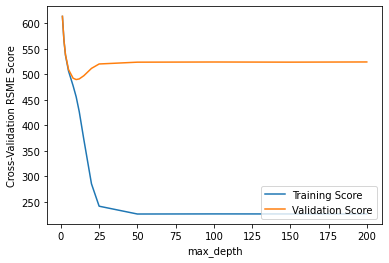

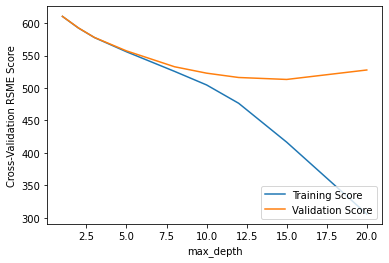

In [44]:

def plot_scores(param_to_scores):

    plt.figure()

    param_to_training_scores = {k: scores[0] for (k, scores) in param_to_scores.items()}
    param_to_validation_scores = {k: scores[1] for (k, scores) in param_to_scores.items()}
    
    # Calculate mean and standard variation across all folds for each parameter value
    training_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_training_scores.items())])
    validation_score_mean = np.array([np.mean(v) for k,v in sorted(param_to_validation_scores.items())])
    
    # Plot error bar
    plt.plot(sorted(param_to_training_scores.keys()), training_score_mean, label ='Training Score')
    plt.plot(sorted(param_to_validation_scores.keys()), validation_score_mean, label ='Validation Score')
    plt.legend(loc='lower right') 
    
    plt.xlabel('max_depth')
    plt.ylabel('Cross-Validation RSME Score')
    plt.show()  

plot_scores(param_to_scores)
plot_scores(param_to_scores_max_f_3)

In [42]:
regressor = RandomForestRegressor(max_depth=10)
pred = regressor.fit(X,y).predict(df_test.to_numpy())

In [43]:

df = pd.DataFrame({'Id': np.arange(len(pred)), 'Predicted': pred})
df.to_csv("./pred/cx_random_forest.csv", index=False)